In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py 
# from sklearn.model_selection import test_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
import copy 
from scipy.io import savemat

## Load dataset

In [16]:
def rs_3d_to_2d(in_3d):
    shape_3d = in_3d.shape
    out_2d = np.reshape(in_3d,(shape_3d[0],shape_3d[1]*shape_3d[2]))
    return out_2d

def rs_2d_to_3d(in_2d,shape_image):
    batch_size=in_2d.shape[0]
    out_3d = np.reshape(in_2d,(batch_size,shape_image[0],shape_image[1]))
    return out_3d

def rs_minmax_txf(in_3d, minmax_scaler):
    image_shape = in_3d.shape[1:]
    out_scaled_3d = rs_2d_to_3d(minmax_scaler.transform(rs_3d_to_2d(in_3d)), image_shape)
    return out_scaled_3d

root_out_dir = '../Datasets/mps_gp_sgram/PyData/'
train_dataset = h5py.File(root_out_dir + 'dsMPS_data_train_file.h5', "r")
print(f"keys={train_dataset.keys()}")

# print(train_dataset)
X_trainOrg = np.array(train_dataset["data_dsMPS_x"][:]) # your train set features
y_train = to_categorical(np.ravel(np.array(train_dataset["data_label_y"][:]))) # your train set labels
img_shape = X_trainOrg.shape[1:]

if not np.array_equal(X_trainOrg, rs_2d_to_3d(rs_3d_to_2d(X_trainOrg), img_shape)):
    print('error - error Should be same')

minmax_scaler = MinMaxScaler()
minmax_scaler.fit(rs_3d_to_2d(X_trainOrg))
X_train = rs_2d_to_3d(minmax_scaler.transform(rs_3d_to_2d(X_trainOrg)), img_shape)
# train_set_x_norm = standard_scaler.transform(train_set_x_orig)


# If we want to train using clean calls only, then take the last 1203 points from the training dataset
X_train_clean = X_train[-1203:,:,:]
y_train_clean = y_train[-1203:,:]

test_dataset = h5py.File(root_out_dir + 'dsMPS_data_test_snrInf.h5', "r")
print(test_dataset)
X_testOrg = np.array(test_dataset["data_dsMPS_x"][:]) # your train set features
X_test = rs_minmax_txf(X_testOrg, minmax_scaler)
y_test = to_categorical(np.ravel(np.array(test_dataset["data_label_y"][:]))) # your train set labels

print(f"Type: X_train={type(X_train)}, y_train={type(y_train)}")
print(f"Shapes: X_train={X_train.shape}, y_train={y_train.shape},X_test={X_test.shape}, y_test={y_test.shape}")

unq_vals, unq_counts = np.unique(y_train, axis=0, return_counts=True)
print(f"unq_vals={unq_vals}, unq_counts={unq_counts}")

print(f"range:min={np.amin(X_train)}, max={np.amax(X_train)}")


keys=<KeysViewHDF5 ['data_dsMPS_x', 'data_label_y']>
<HDF5 file "dsMPS_data_test_snrInf.h5" (mode r)>
Type: X_train=<class 'numpy.ndarray'>, y_train=<class 'numpy.ndarray'>
Shapes: X_train=(5410, 80, 69), y_train=(5410, 5),X_test=(402, 80, 69), y_test=(402, 5)
unq_vals=[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]], unq_counts=[ 388  526 1567 1116 1813]
range:min=0.0, max=1.0000000000000004


## Train a CNN  on noisy data 

In [9]:
tf.random.set_seed(1234)  # applied to achieve consistent results

# Define the model 
CNNmodel_noisy = tf.keras.Sequential([
    ## ZeroPadding2D with padding 3, input shape of 80 x 69 x 1
    ## Conv2D with 32 5x5 filters and stride of 1
    ## BatchNormalization for axis 3
    ## ReLU
    ## Max Pooling 2D with default parameters
    ## Flatten layer
    ## Dense layer with 1 unit for output & 'sigmoid' activation            
        
    # YOUR CODE STARTS HERE
    tf.keras.layers.ZeroPadding2D(padding=3,input_shape=(80,69,1)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5),padding='same', strides=(1,1)),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units=5, activation='softmax'),
    # YOUR CODE ENDS HERE
    ])

CNNmodel_noisy.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
CNNmodel_noisy.summary()

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)
history_noisy = CNNmodel_noisy.fit(train_dataset, epochs=50, validation_data=test_dataset)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 86, 75, 1)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 86, 75, 16)        416       
                                                                 
 batch_normalization (BatchN  (None, 86, 75, 16)       64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 86, 75, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 43, 37, 16)       0         
 )                                                               
                                                        

## Train a CNN  on clean data 

In [10]:
tf.random.set_seed(1234)  # applied to achieve consistent results

# Define the model 
CNNmodel_clean = tf.keras.Sequential([
    ## ZeroPadding2D with padding 3, input shape of 80 x 69 x 1
    ## Conv2D with 32 5x5 filters and stride of 1
    ## BatchNormalization for axis 3
    ## ReLU
    ## Max Pooling 2D with default parameters
    ## Flatten layer
    ## Dense layer with 1 unit for output & 'sigmoid' activation            
        
    # YOUR CODE STARTS HERE
    tf.keras.layers.ZeroPadding2D(padding=374),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5),padding='same', strides=(1,1)),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units=5, activation='softmax'),
    # YOUR CODE ENDS HERE
    ])

CNNmodel_clean.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
CNNmodel_clean.summary()

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_clean, y_train_clean)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)
history_clean = CNNmodel_clean.fit(train_dataset, epochs=50, validation_data=test_dataset)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_1 (ZeroPaddi  (None, 86, 75, 1)        0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 86, 75, 16)        416       
                                                                 
 batch_normalization_1 (Batc  (None, 86, 75, 16)       64        
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 86, 75, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 37, 16)       0         
 2D)                                                             
                                                      

## Check output of NN model 

13/13 [==============================] - 0s 2ms/step
Unique values in y_train_pred_NN=[0 1 2 3 4]
Unique values in y_test_pred_NN=[0 1 2 3 4]
Training accuracy=0.85452865064695
 Testing accuracy=0.8855721393034826



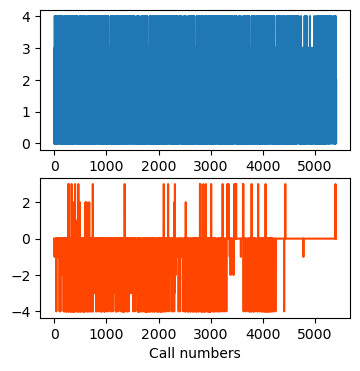

In [11]:
# Clean 

y_train_pred_NN_clean = np.argmax(CNNmodel_clean.predict(X_train_clean), axis=1)
y_train_true_clean= np.argmax(y_train_clean, axis=1)

train_accuracy_cleanCNN = np.sum(y_train_true_clean==y_train_pred_NN_clean)/len(y_train_true_clean)

# Noisy 

y_train_pred_NN_noisy = np.argmax(CNNmodel_noisy.predict(X_train), axis=1)
y_test_pred_NN_noisy = np.argmax(CNNmodel_noisy.predict(X_test), axis=1)
y_train_true_noisy= np.argmax(y_train, axis=1)
y_test_true_noisy= np.argmax(y_test, axis=1)

train_accuracy_noisyCNN = np.sum(y_train_true_noisy==y_train_pred_NN_noisy)/len(y_train)

print(f"Unique values in y_train_pred_NN={np.unique(y_train_pred_NN_noisy)}")
print(f"Unique values in y_test_pred_NN={np.unique(y_test_pred_NN_noisy)}")

fig, ax = plt.subplots(2,1,figsize=(4,4))
ax[0].plot(y_train_true_noisy)
ax[1].plot(y_train_true_noisy-y_train_pred_NN_noisy, color = "orangered")
ax[1].set_xlabel("Call numbers")


print(f"Training accuracy={train_accuracy_noisyCNN}\n Testing accuracy={np.sum(y_test_true_noisy==y_test_pred_NN_noisy)/len(y_test_true_noisy)}\n")

## Test in different SNRs 

../Datasets/mps_gp_sgram/PyData/dsMPS_data_test_snr-20.h5
<HDF5 file "dsMPS_data_test_snr-20.h5" (mode r)>
13/13 [==============================] - 0s 1ms/step
Testing accuracy=0.0945273631840796

../Datasets/mps_gp_sgram/PyData/dsMPS_data_test_snr-15.h5
<HDF5 file "dsMPS_data_test_snr-15.h5" (mode r)>
13/13 [==============================] - 0s 2ms/step
Testing accuracy=0.12686567164179105

../Datasets/mps_gp_sgram/PyData/dsMPS_data_test_snr-10.h5
<HDF5 file "dsMPS_data_test_snr-10.h5" (mode r)>
13/13 [==============================] - 0s 2ms/step
Testing accuracy=0.1865671641791045

../Datasets/mps_gp_sgram/PyData/dsMPS_data_test_snr-5.h5
<HDF5 file "dsMPS_data_test_snr-5.h5" (mode r)>
13/13 [==============================] - 0s 2ms/step
Testing accuracy=0.41044776119402987

../Datasets/mps_gp_sgram/PyData/dsMPS_data_test_snr0.h5
<HDF5 file "dsMPS_data_test_snr0.h5" (mode r)>
13/13 [==============================] - 0s 2ms/step
Testing accuracy=0.5422885572139303

../Datasets/mps_gp_

([<matplotlib.axis.XTick at 0x1daa527e9a0>,
 [Text(-20.0, 0, '-20'),
  Text(-15.0, 0, '-15'),
  Text(-10.0, 0, '-10'),
  Text(-5.0, 0, '-5'),
  Text(0.0, 0, '0'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(15.0, 0, ''),
  Text(20.0, 0, '$\\infty$'),
  Text(25.0, 0, ''),
  Text(30.0, 0, 'Training')])

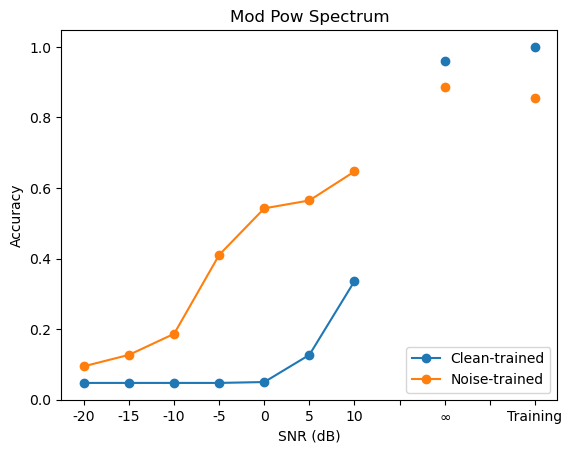

In [12]:
all_snrs= np.arange(-20.0, 11, 5)
all_snrs= np.append(all_snrs, np.inf)

test_accuracy_noisyCNN = np.zeros((all_snrs.shape))
test_accuracy_cleanCNN = np.zeros((all_snrs.shape))

for snr_value,iter in zip(all_snrs,range(all_snrs.shape[0])):
    if np.isinf(snr_value):
        out_dsMPS_data_test_file= root_out_dir + 'dsMPS_data_test_snrInf.h5'
    else: 
        out_dsMPS_data_test_file= root_out_dir + 'dsMPS_data_test_snr' + str(np.int_(snr_value)) + '.h5'
    print(out_dsMPS_data_test_file)

    test_dataset = h5py.File(out_dsMPS_data_test_file, "r")
    print(test_dataset)
    X_test_snr = np.array(test_dataset["data_dsMPS_x"][:]) # your train set features
    y_test_snr = np.ravel(np.array(test_dataset["data_label_y"][:])) # your train set labels
    y_test_pred_NN_noisy = np.argmax(CNNmodel_noisy.predict(rs_minmax_txf(X_test_snr,minmax_scaler)), axis=1)
    y_test_pred_NN_clean = np.argmax(CNNmodel_clean.predict(rs_minmax_txf(X_test_snr,minmax_scaler)), axis=1)

    test_accuracy_noisyCNN[iter] = np.sum(y_test_snr==y_test_pred_NN_noisy)/len(y_test_snr)
    test_accuracy_cleanCNN[iter] = np.sum(y_test_snr==y_test_pred_NN_clean)/len(y_test_snr)
    print(f"Testing accuracy={test_accuracy_noisyCNN[iter]}\n")

plot_snr= copy.deepcopy(all_snrs)
plot_snr[np.isinf(plot_snr)] = 20
plot_snr = np.append(plot_snr[:-1], [15, plot_snr[-1], 25, 30])
plot_snr_label = [str(item.astype('int')) for item in plot_snr[:-4]] + [''] + ['$\infty$'] + [''] + ['Training']
plt_accuracy_clean = np.append(test_accuracy_cleanCNN[:-1], [np.nan, test_accuracy_cleanCNN[-1], np.nan, train_accuracy_cleanCNN])
plt_accuracy_noisy = np.append(test_accuracy_noisyCNN[:-1], [np.nan, test_accuracy_noisyCNN[-1], np.nan, train_accuracy_noisyCNN])

plt.plot(plot_snr, plt_accuracy_clean, 'o-', label="Clean-trained")
plt.plot(plot_snr, plt_accuracy_noisy, 'o-', label="Noise-trained")
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.title("Mod Pow Spectrum")
plt.legend(loc='lower right')
plt.xticks(ticks=plot_snr, labels=plot_snr_label)

In [25]:
doSave = True
if doSave:
    out_dsMPS_classify_file = root_out_dir + 'dsMPS_classify_out'
    np.savez(out_dsMPS_classify_file + '.npz', all_snrs=all_snrs, test_accuracy_noisyCNN=test_accuracy_noisyCNN, test_accuracy_cleanCNN=test_accuracy_cleanCNN)
    # mat_dict= {"all_snrs":all_snrs, "test_accuracy_noisyCNN":test_accuracy_noisyCNN, "test_accuracy_cleanCNN":test_accuracy_cleanCNN}
    mat_dict= {"all_snrs":all_snrs, "train_accuracy_cleanCNN":train_accuracy_cleanCNN, "train_accuracy_noisyCNN":train_accuracy_noisyCNN, \
    "test_accuracy_cleanCNN":test_accuracy_cleanCNN, "test_accuracy_noisyCNN":test_accuracy_noisyCNN}
    savemat(out_dsMPS_classify_file + '.mat', mat_dict)